<a href="https://colab.research.google.com/github/grosed/5Rs-talk-and-workshop/blob/main/groups/group-D/active_changepoint_detection_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries
unsure on the bayes opt , we make some assumptions. \\
 \\
bo lib doesnt seem correct. We later have a self.bo.plot_gp() which isn't a function we've defined.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
#import change_point_detection.cpd
#from change_point_detection import cpd
!pip install bayesian-optimization
import bayes_opt as bo
!pip install python-utils
import python_utils

#scp -r ./acpd hayashi@10.229.41.223:/home/hayashi/Program/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Found his function- it's in R Tho

avgDiff <- function(data, attribute.col, k, ranks=1, power = 1, mode="linear") {
  require(data.table)
  require(FNN)
  require(sp)
  
  knn <- get.knn(sp::coordinates(data), k=k)
  near.neighbors <- as.data.table(knn)
  
  if (mode == "linear") {
    near.neighbors <- near.neighbors[,(k+1):ncol(near.neighbors)]
    near.neighbors$sum <- rowSums(near.neighbors, na.rm = FALSE, dims = 1)
    weights <- near.neighbors[,1:(ncol(near.neighbors)-1)]/near.neighbors$sum
  }
  
  if (mode == "inverse") {
    near.neighbors <- near.neighbors[,(k+1):ncol(near.neighbors)]
    weights <-(1/(near.neighbors^power))
  }
  
  col <- which(colnames(data@data)==attribute.col)
  attributes <- data@data[c(knn$nn.index), col]
  attributes <- data.frame(matrix(unlist(attributes), ncol=k), stringsAsFactors=FALSE)
  
  table <- cbind(seq(1:nrow(attributes)), attributes)
  
  difference <- abs(data@data[c(table[,1]), col] - table[,2:ncol(table)])
  
  weighted_difference <- as.data.table(difference) * weights
  
  result <- as.data.table(cbind(seq(1:nrow(weighted_difference)), as.data.table(rowSums(weighted_difference))))
  names(result) <- c("ID", "AvgDiff")
  result <- result[order(-AvgDiff)]
  
  data$id <- 1:nrow(data)
  ranked_diffs <- result[1:2000,1]
  data <- subset(data, !data$Id %in% as.list(ranked_diffs$ID))
  data
}

Issue is he doesnt provide change_point_detection.cpd. We need to find another package to sub that in. In the code below he just uses some linear regression likelihood selection method to replace.

In [ ]:
class ActiveChangePointDetection:
    def __init__(self, init_X, init_Y, bounds=[{},{}], cpd='linear_likelihood', strategy='bo', acq='ei', kern='rbf', estimate_method='mean', exclude_initial_X=True, centerize_input=False):
        '''
        attribute order of init_X must be same as bounds
            e.g. of bounds with attributes (c1, d2): [{'name': 'c1', 'type': 'continuous', 'domain': [1,2,3]}, {'name': 'd1', 'type': 'discrete', 'domain': [11,12]}]
        cpd:'linear_likelihood', '3poly_likelihood'
        '''
        self.input_dim = len(bounds)
        self.X = init_X.reshape(-1, self.input_dim)
        self.centerized_X = None
        self.output_dim = init_Y.reshape(self.X.shape[0], -1).shape[1]
        self.Y = init_Y.reshape(-1, self.output_dim)
        self.centerized_Y = None

        self.bounds = bounds
        self.estimate_method = estimate_method
        self.C = None # change scores

        self.centerize_input = centerize_input

        if self.input_dim == 1:
            self.original_input_set = np.asarray(bounds[0]['domain']).reshape(-1, self.input_dim)
        else:
            self.original_input_set = np.asarray(list(itertools.product(*[var['domain'] for var in bounds]))).reshape(-1, self.input_dim) # ndarray
        if exclude_initial_X:
            self.rest_input_set = utility.remove_duplicate_array(self.original_input_set, init_X.reshape(-1,self.input_dim), dim=self.input_dim)
            #list(set(self.original_input_set) - set(init_X.reshape(-1,self.input_dim)))
        else:
            self.rest_input_set = self.original_input_set

        # change-point detector
        self.cpd = cpd # 'linear_likelihood', '3poly_likelihood'
        # initialize change score calculator
        if self.cpd == 'linear_likelihood':
            self.change_score_calculator = change_point_detection.cpd.LinearRegressionCPDetector(basis_func='raw')
        elif self.cpd == '3poly_likelihood':
            self.change_score_calculator = change_point_detection.cpd.LinearRegressionCPDetector(basis_func='3poly')

        # determination Strategy
        self.strategy = strategy
        # bayesian optimization
        self.acq = acq
        self.kern = kern

        if len(bounds) == 1:
            self.sorted_i = np.argsort(self.X) # set
        else:
            # multi-input
            pass

        # do not use unobserved bounds, because not clearly control with check function for same next_input

        # estimates
        self.max_c = None
        self.max_x = None
        self.predictive_cs_mean = None # corresponds to self.input_domain
        self.predictive_cs_var = None

        self.estimated_CP = []

        # miscelleneous data
        self.iteration_n = 0

        # initialization change-point detection for itinial data
        _ = self.determine_next_input()

    def determine_next_input(self, X=None, y=None, num_restarts=1):
        # compute change scores
        if X is not None: # with report_data
            self.X = X
            self.Y = y
        self.change_score_calculator.fit(self.X, self.Y)
        self.C = self.change_score_calculator.compute_change_score(self.X, self.Y)
        if self.strategy == 'bo':
            # Bayesian optimization
            if self.centerize_input: # to slip to centers of adjacent inputs
                sorting_i = self.X.ravel().argsort()
                sorted_X = self.X[sorting_i]
                sorted_C = self.C[sorting_i]

                self.centerized_X = ((sorted_X[1:] + sorted_X[:-1]) / 2).reshape(-1,self.input_dim)
                self.centerized_C = sorted_C[1:].reshape(-1,1)
                self.bo = bo.BayesianOptimization(init_X=self.centerized_X, init_Y=self.centerized_C, input_set=self.rest_input_set, kern=self.kern, exclude_initial_X=False, num_restarts=num_restarts)
            else:
                self.bo = bo.BayesianOptimization(init_X=self.X, init_Y=self.C, bounds=self.bounds, kern=self.kern, exclude_initial_X=True, num_restarts=num_restarts)
            next_input = self.bo.determine_next_input(acq=self.acq)
        elif self.strategy == 'greedy':
            # greedy only for 1-d input
            sorting_i = self.X.ravel().argsort()
            sorted_X = self.X[sorting_i]
            sorted_Y = self.Y[sorting_i]
            sorted_C = self.C.ravel()[sorting_i]
            sorted_max_i = sorted_C.ravel().argmax()
            if sorted_max_i == 0:
                next_i = sorted_max_i + 1
            elif sorted_max_i == len(sorted_C) - 1:
                next_i = sorted_max_i - 1
            elif sorted_C[sorted_max_i+1] > sorted_C[sorted_max_i-1]:
                next_i = sorted_max_i + 1
            elif sorted_C[sorted_max_i+1] < sorted_C[sorted_max_i-1]:
                next_i = sorted_max_i - 1
            else: # for equal
                next_i = sorted_max_i + np.random.choice([-1, 1])
            greedy_middle_x = (sorted_X[sorted_max_i] + sorted_X[next_i]) / 2
            next_input = utility.find_nearest_value(self.rest_input_set, greedy_middle_x)
        elif self.strategy == 'random':
            next_input = self.rest_input_set[np.random.choice(np.arange(len(self.rest_input_set)))].reshape(1, self.input_dim)
        return next_input

    def report(self, new_input, new_output):
        new_input.shape = (1, self.input_dim)
        new_output.shape = (1, self.output_dim)
        self.X = np.r_[self.X, new_input]
        self.Y = np.r_[self.Y, new_output]
        self.rest_input_set = utility.remove_duplicate_array(self.rest_input_set, new_input, dim=self.input_dim)

        self.iteration_n += 1

    def estimate_cp(self, X=None, Y=None, method=None, num_restarts=1):
        # todo: not ready for multi change-points
        '''
        param:mean:string:'mean' gp estimated, 'data' data max
        '''
        if method is None:
            method = self.estimate_method
        # compute change scores
        if X is None: # with report_data
            X = self.X
            Y = self.Y
        self.change_score_calculator.fit(X, Y)
        C = self.change_score_calculator.compute_change_score(X, Y)

        if self.centerize_input:
            sorting_i = X.ravel().argsort()
            sorted_X = X[sorting_i]
            sorted_C = C[sorting_i]

            X = centerized_X = ((sorted_X[1:] + sorted_X[:-1]) / 2).reshape(-1,self.input_dim)
            C = centerized_C = sorted_C[1:].reshape(-1,1)

        if method == 'data':
            return X[C.argmax()]
        elif method == 'mean':
            # Bayesian optimization
            bayesian_optimizer = bo.BayesianOptimization(init_X=X, init_Y=C, bounds=self.bounds, kern=self.kern, exclude_initial_X=True, num_restarts=num_restarts)
            return bayesian_optimizer.estimate_max(method=method)

    def plot_XYC(self, t=-1, cp=None, fontsize=16, fig_name=None, fig_format='pdf', fig_dpi=300, method=None):
        '''
        machigatteru
        plot Data from iter_n=0 to iter_n=t, and c(x) at iter_n=t
        '''
        if self.input_dim != 1 or self.output_dim != 1:
            raise Exception('inut dim and output dim must be one')
        if method is None:
            method = self.estimate_method

        cp = np.asarray(cp)

        fig, ax1 = plt.subplots()
        if t == -1:
            iter_n = len(self.X)
        elif t < -1:
            iter_n = t + 1
        elif t > 0:
            iter_n = len(self.X) - self.iteration_n + t + 1

        X = self.X[:iter_n].ravel()
        Y = self.Y[:iter_n].ravel()
        sorting_i = X.argsort()
        sorted_X = X[sorting_i]
        sorted_Y = Y[sorting_i]
        self.change_score_calculator.fit(sorted_X, sorted_Y)
        C = self.change_score_calculator.compute_change_score(sorted_X.reshape(-1,self.input_dim), sorted_Y.reshape(-1,self.output_dim))
        plt1 = ax1.plot(sorted_X, sorted_Y, 'k^-', label='Data')

        plt3 = ax1.axvline(x=self.X[t], linestyle='--', color='blue', label='New input')
        if cp.size == 1:
            plt4 = ax1.axvline(x=self.estimate_cp(sorted_X.reshape(-1,self.input_dim), sorted_Y.reshape(-1,self.output_dim), method=method), linestyle='-.', color='red', label='Estimated cp')

        ax1.set_ylabel('Output', fontsize=fontsize)
        ax1.set_xlabel('Input', fontsize=fontsize)

        ax2 = ax1.twinx()
        if self.centerize_input:
            centerized_X = (sorted_X[1:] + sorted_X[:-1]) / 2
            centerized_C = C[1:] # C is already sorted
            plt2 = ax2.plot(centerized_X, centerized_C, 'ro-', label='Change score')
        else:
            plt2 = ax2.plot(sorted_X, C, 'ro-', label='Change score')
        ax2.set_ylabel('Change score', fontsize=fontsize)

        if cp is not None:
            if cp.size == 1:
                #plt.xticks(rotation=70)
                #ax2.xticks(rotation=70)
                plt5 = ax1.axvline(x=cp, linestyle=':', color='green', label='True cp')
                lns = plt1 + plt2 + [plt3, plt4, plt5]
                # plt.xticks(list(plt.xticks()[0]) + [cp], rotation =30) if add this line, ax1 and ax2 goes away
                ''' to rotate ax1 and ax2 subplots
                for ax in fig.axes:
                    plt.sca(ax)
                    plt.xticks(rotation=70)
                '''
            elif cp.size > 1:
                plt5 = ax1.axvline(x=cp[0], linestyle=':', color='green', label='True cp')
                for i in range(1, len(cp)):
                    ax1.axvline(x=cp[i], linestyle=':', color='green')
                lns = plt1 + plt2 + [plt3, plt5]
        else:
            if cp.size == 1:
                lns = plt1 + plt2 + [plt3, plt4]
            elif cp.size > 1:
                lns = plt1 + plt2 + [plt3, plt5]

        margin = self.original_input_set.ptp() / 20
        ax1.set_xlim(self.original_input_set[0] - margin, self.original_input_set[-1] + margin)

        #lns = [plt1+plt2, plt3]
        #lns = (plt1+plt2).append(plt3)

        #labs = [plt1.get_label(), plt2.get_label(), plt3.get_label()]
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs)

        if fig_name != None:
            plt.savefig(fig_name, format=fig_format, dpi=fig_dpi, bbox_inches='tight')
            plt.close()


We have zero clue what the "bo" package is bu it doesnt look like what we've got. here we have a self reference .bo.plot_gp() -> which makes no sense.

In [ ]:
class ActiveChangePointDetection0:
    '''
    Exploration Strategy:
        LikelihoodSearch
        GradientSearch
    '''
    def __init__(self, init_X=None, init_Y=None, interactive=True, func=False, bounds={'x1':np.arange(0,100,1000)}):
        self.init_sample_n = 5

        if bounds == None:
            raise AttributeError('Attribute \'bounds\'={\'x1\': set of inputs} is necessary')

        if init_X is None or len(init_X) < self.init_sample_n:
            raise AttributeError('# of init_X must be larger than %d' % self.init_sample_n)

        # variables
        #self.queries = bounds
        self.X = list(init_X) # input
        '''future work: how sort multi inputs?'''
        self.sorted_i = [np.argsort(init_X.ravel())] # sorted input
        self.Y = list(init_Y) # output
        self.bounds = bounds
        #self.rest_input_set = np.setdiff1d(bounds['x1'], init_X).reshape(-1,1)
        #self.rest_bounds = bounds
        self.rest_bounds = {}
        self.rest_bounds['x1'] = np.setdiff1d(bounds['x1'], init_X).reshape(-1,1)

        # core variables
        self.c = list() # change point confidence c(x)
        self.c_X = list() # inputs for change point confidence c(x)
        self.c_sorted_i = list() # indices of inputs for change point confidence c(x)
        self.max_c_x = list()
        self.convergence_criterion = list() # convergence if small enough

        # setting parameters
        self.onedata_score = -40 # -1.2
        self.twodata_score = -20 # -2.7

        self.input_dim = len(bounds)
        self.iteration_n = 0


    def update_data(self, new_input, new_output):
        if new_input in self.X:
            raise Exception('New input already in sampled inputs')
        self.rest_bounds['x1'] = np.setdiff1d(self.rest_bounds['x1'], np.array(new_input)).reshape(-1,1)
        self.X.append(new_input)
        self.Y.append(new_output)
        self.sorted_i.append(np.argsort(np.array(self.X).ravel())) # future work: how sort multi input?
        self.iteration_n += 1

    def plot_XYC(self, t=-1, cp=None, fontsize=16, fig_name=None, fig_format='png', fig_dpi=300):
        '''
        plot Data from iter_n=0 to iter_n=t, and c(x) at iter_n=t
        '''
        fig, ax1 = plt.subplots()
        if t == -1:
            iter_n = len(self.X) - 1
        elif t < 0:
            iter_n = t + 1
        elif t > 0:
            iter_n = len(self.X) - self.iteration_n + t + 1
        plt1 = ax1.plot(np.array(self.X)[:iter_n+1][self.sorted_i[t]], np.array(self.Y)[:iter_n+1][self.sorted_i[t]], 'ko-', label='Data')

        plt3 = ax1.axvline(x=self.X[t], linestyle='--', color='blue', label='Sampled input')
        plt4 = ax1.axvline(x=self.max_c_x[t], linestyle='-.', color='red', label='Calculated cp')

        ax1.set_ylabel('Output', fontsize=fontsize)
        ax1.set_xlabel('Input', fontsize=fontsize)

        ax2 = ax1.twinx()
        plt2 = ax2.plot(np.array(self.c_X)[t][self.c_sorted_i[t]], np.array(self.c)[t][self.c_sorted_i[t]], 'ro-', label='$s(x)$')
        ax2.set_ylabel('$s(x)$', fontsize=fontsize)

        if cp != None:
            #plt.xticks(rotation=70)
            #ax2.xticks(rotation=70)
            plt5 = ax1.axvline(x=cp, linestyle=':', color='green', label='Ground cp')
            lns = plt1 + plt2 + [plt3, plt4, plt5]
            # plt.xticks(list(plt.xticks()[0]) + [cp], rotation =30) if add this line, ax1 and ax2 goes away
            ''' to rotate ax1 and ax2 subplots
            for ax in fig.axes:
                plt.sca(ax)
                plt.xticks(rotation=70)
            '''
        else:
            lns = plt1 + plt2 + [plt3, plt4]

        #lns = [plt1+plt2, plt3]
        #lns = (plt1+plt2).append(plt3)

        #labs = [plt1.get_label(), plt2.get_label(), plt3.get_label()]
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs)

        if fig_name != None:
            plt.savefig(fig_name, format=fig_format, dpi=fig_dpi, bbox_inches='tight')
            plt.close()

    def plot_GP(self, bounds=None):
        if bounds == None:
            self.bo.plot_gp(bounds=self.bounds)
        else:
            self.bo.plot_gp(bounds=bounds)




Coding in example functions

In [ ]:
XRange=range(0,250)
PTBias=[0.1*x+30 for x in XRange if x < 143.15]+[0.1*x + 60 for x in XRange if x > 143.15]
PTBias=np.array(PTBias)
SD=20
Errors=np.random.randn(len(PTBias))*SD
PTBias=PTBias+Errors
ActiveChangePointDetection0(init_X=XRange,init_Y=PTBias)

AttributeError: ignored

In [ ]:
XRange=np.arange(0,250)
PTBias=[0.1*x+30 for x in XRange if x < 143.15]+[0.1*x + 60 for x in XRange if x > 143.15]
PTBias=np.array(PTBias)
SD=20
Errors=np.random.randn(len(PTBias))*SD
PTBias=PTBias+Errors
autput = ActiveChangePointDetection0(init_X=XRange,init_Y=PTBias)

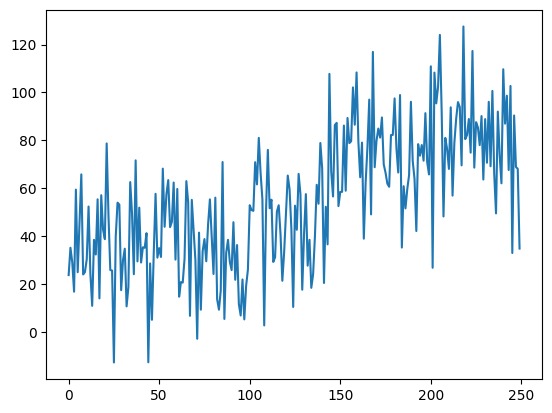

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(XRange,PTBias)

#autput.max_c_x

In [ ]:
autput.plot_GP()

AttributeError: ignored